## TTC Subway Delay Data Exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

### Load Data

In [ ]:
dd = pd.read_csv("/content/ttc-subway-delay-data-2022.csv")
dd_codes = pd.read_csv("/content/ttc-subway-delay-codes.csv")

dd.rename(columns={'Min Delay': 'delay', 'Min Gap': 'added_gap', 'Code': 'code'}, inplace=True)

I've decided to go-ahead with 2022 data only because it the latest year with data for each month, which can be helpful to see time-based trends e.g seasonality etc.

### Initial Exporation

In [ ]:
### Data Quality - check for nulls in the data
dd.isnull().sum()[dd.isnull().sum() != 0]

Bound    5546
Line       39
dtype: int64

Off ~20k delay records, 5.5k i.e ~27% records do not have information on Bounds, which is not a critical feature for most of our analysis. However, 39 records having no Line is crutial. We will not remove this data for the most of our time-series based analysis bits, but would remove later when we'll run experiments pivoting Line informaton.

In [ ]:
dd_df = pd.merge(dd, dd_codes, how='left', on='code')

We can also see the data needs some cleaning/handling.

1. There are many version of YU/DB lines mentioned and they all have very few number of delays. We are removing such rows and are only going ahead with top 4 lines i.e. YU, BD, SRT and SHP. Another reason for not cleaning this dataset and dropping is: the mean delays for the aforementioend cases is close to zero.

2. After joining, we can see ~500 records didn't find a valid code description. Once again, we won't drop these records to use other features. Hopefully, these records won't have any significant trend based on delay codes and we won't be concerned about the reasons.

In [ ]:
dd_df = dd_df[dd_df['Line'].isin(['YU', 'BD', 'SHP', 'SRT'])]

### Feature Engineering

In [ ]:
## I reckon hour and day-of-month can be interesting features to look at. Hence we'll engineer these features from the Date and Time fields respectively
dd_df['Hour'] = dd_df['Time'].str[:2].astype(int)
dd_df['DOM'] = pd.to_datetime(dd_df['Date']).dt.day.astype(int)
dd_df['Month'] = pd.to_datetime(dd_df['Date']).dt.month.astype(int)

### Exploratory Data Analysis

#### Section 1.  Which Lines face the most delays, and are there any trends/patterns

In [ ]:
agg_dd_df = dd_df.groupby(['Line']).aggregate({'delay': ['count','mean']})
agg_dd_df.columns = [f'{agg}_{col}' for col, agg in agg_dd_df.columns]
agg_dd_df.reset_index().rename(columns={'delay_count': 'Count', 'delay_mean': 'Mean'}).sort_values(by='count_delay', ascending=False)

,Line,count_delay,mean_delay
3,YU,10637,3.531635
0,BD,6788,3.707867
2,SRT,1196,6.105351
1,SHP,852,3.585681


We have sorted the resultant dataset (above) by number of delay events (delay frequency)

Insights:
<br> 1. We can see most delays (~53%) are reported for Yonge-University line. We'd investigate its Stations later in more granularity.
<br> 2. Scarborough line seems to facing the longest delays when they happen i.e. about x2 longer than delays reported elsewhere. We'll investigate it's stations as well to see if we can find any specific station being an outlier, disrupting the whole mean

In [ ]:
agg2_dd_df = dd_df.groupby(['Line', 'Bound']).aggregate({'delay': ['count','mean']})
agg2_dd_df.columns = [f'{agg}_{col}' for col, agg in agg2_dd_df.columns]
agg2_dd_df = agg2_dd_df.reset_index().rename(columns={'Line': 'Line', 'Bound': 'Bound', 'delay_count': 'Count', 'delay_mean': 'Mean'}).sort_values(by='count_delay', ascending=False)
agg2_dd_df = agg2_dd_df.sort_values(by=['Line', 'Bound']).reset_index()
dd_df.groupby(['Line', 'Bound']).aggregate({'delay': ['count','mean']})

delay           
           count       mean
Line Bound                 
BD   B         3   0.000000
     E      2292   5.013525
     N        14   3.928571
     S        15   4.800000
     W      2431   5.510901
SHP  B         1  11.000000
     E       357   4.924370
     N         1   6.000000
     S         2   4.000000
     W       307   4.026059
SRT  B        91   0.000000
     E         6   2.000000
     N       327   8.541284
     S       291  13.333333
     W         4   8.000000
YU   B         5   0.600000
     E        13   4.461538
     N      3569   4.687588
     S      4596   4.378590
     W        14   1.857143

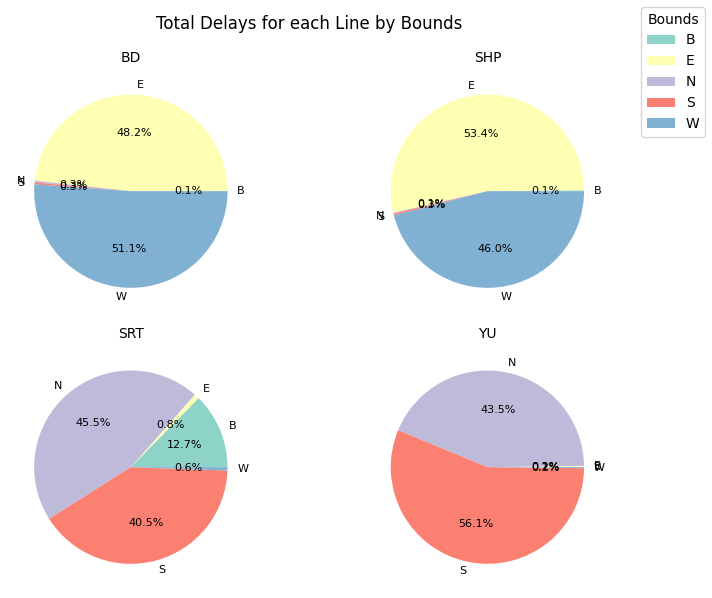

In [ ]:
grouped_df = agg2_dd_df.groupby('Line')
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

legend_labels = agg2_dd_df['Bound'].unique()
legend_colors = sns.color_palette('Set3', len(legend_labels))

# Iterate over each Line group
for i, (name, group) in enumerate(grouped_df):
    bounds = group['Bound']
    count_delays = group['count_delay']
    ax = axes[i // 2, i % 2]
    wedges, _, autotexts = ax.pie(count_delays, labels=bounds, autopct='%1.1f%%', colors=legend_colors, textprops={'fontsize': 8})
    ax.set_title(f'{name}', fontsize= 10)

fig.legend(legend_labels, title='Bounds', loc='upper right', fontsize= 10)
plt.suptitle('Total Delays for each Line by Bounds')
plt.tight_layout()
plt.show()


***Insights***:
<br> 1. BD and SHP are horizontal lines, YU is verticle. However, SRT is a mix of both directions and there delays also showcase similar results.
<br> 2. For SHP, East Bound gets delayed the more often than West Bound. While there is a pattern, it is not the most significant one and also SHP gets delayed the least of the four lines. Hence this is not worth exploring any further.
<br> 3. YU gets delayed the most and also have a significant trend where South Bound trains would suffer the most. We'll keep taking more interest in this line in our later experiments.
<br> 4. For SRT, North Bound train seems to be facing more difficulties than the South Bound.

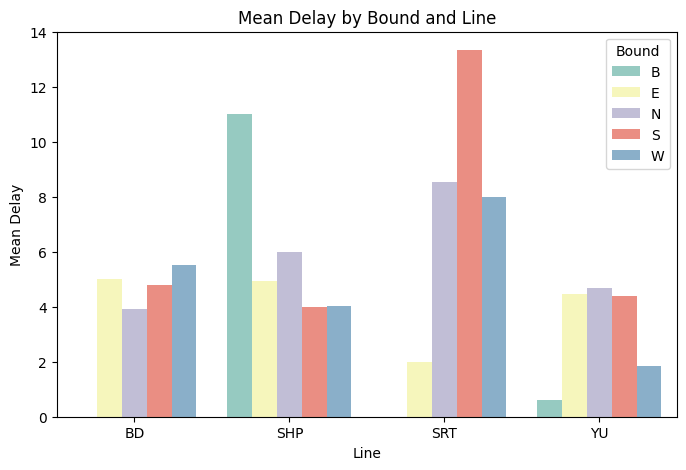

In [ ]:
bound_order = ['B', 'E', 'N', 'S', 'W']

grouped_df = agg2_dd_df.groupby(['Line', 'Bound']).mean_delay.mean().reset_index()
grouped_df['Bound'] = pd.Categorical(grouped_df['Bound'], categories=bound_order)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=grouped_df, x='Line', y='mean_delay', hue='Bound', palette='Set3', ax=ax)

plt.title('Mean Delay by Bound and Line')
plt.xlabel('Line')
plt.ylabel('Mean Delay')
plt.legend(title='Bound', loc='upper right')
plt.show()

***Insights***:
<br> 1. BD and YU have the least mean delay time regardless of the bounds. However, for YU, both North Bound and South Bound seems to be taking equal amount of time when they get delayed, with Noth one taking slightly more.
<br> 2. For SHP, however, East Bound doesn't only faces more frequent issues, but also takes longer to resolve.
<br> 3. SRT South Bound needs to be investigated further as it contributes to more than 40% of overall delays for this line and its resolution time is the longest the city residents face: >13 minutes on average. Earlier, we had observed SRT to be facing an overall higher (x2) delay time and now we know the culprits are South Bounds. However, this line overall needs work because its North bound also is the second worst in the whole GTA.

#### Section 2.  Which Stations face the most delays, and are there any trends/patterns

In [ ]:
agg3_dd_df = dd_df.groupby('Station').agg({'delay': ['count', 'mean']})
agg3_dd_df.columns = [f'{agg}_{col}' for col, agg in agg3_dd_df.columns]
agg3_dd_df['impact'] = agg3_dd_df['count_delay'] * agg3_dd_df['mean_delay']
agg3_dd_df.reset_index().sort_values(by='count_delay', ascending=False).head(10).drop(columns={'impact'})

,Station,count_delay,mean_delay
63,FINCH STATION,1188,2.581650
57,EGLINTON STATION,745,3.515436
12,BLOOR STATION,661,2.358548
90,KENNEDY BD STATION,602,3.365449
231,VAUGHAN MC STATION,590,2.677966
201,ST GEORGE YUS STATION,515,3.755340
105,KIPLING STATION,491,3.458248
260,YONGE BD STATION,412,4.310680
45,DUNDAS STATION,406,2.652709
214,UNION STATION,362,2.839779


We already know YU and BD gets delayed the most and it would have been a surprise if stations belonging to other lines would pop up to be the most frequent delays.

***INTERESTING INSIGHT***

I have, however, found a trend/correlation which definitely cannot be a causation, but it is worth mentioning: There are only 9 stations in whole TTC subway system having public washrooms and 6 of the ones listed above are amongst those. See the image below: Finch, Eglinton, Bloor, Kennedy, Vaughan MC and Kipling all have the public washrooms.

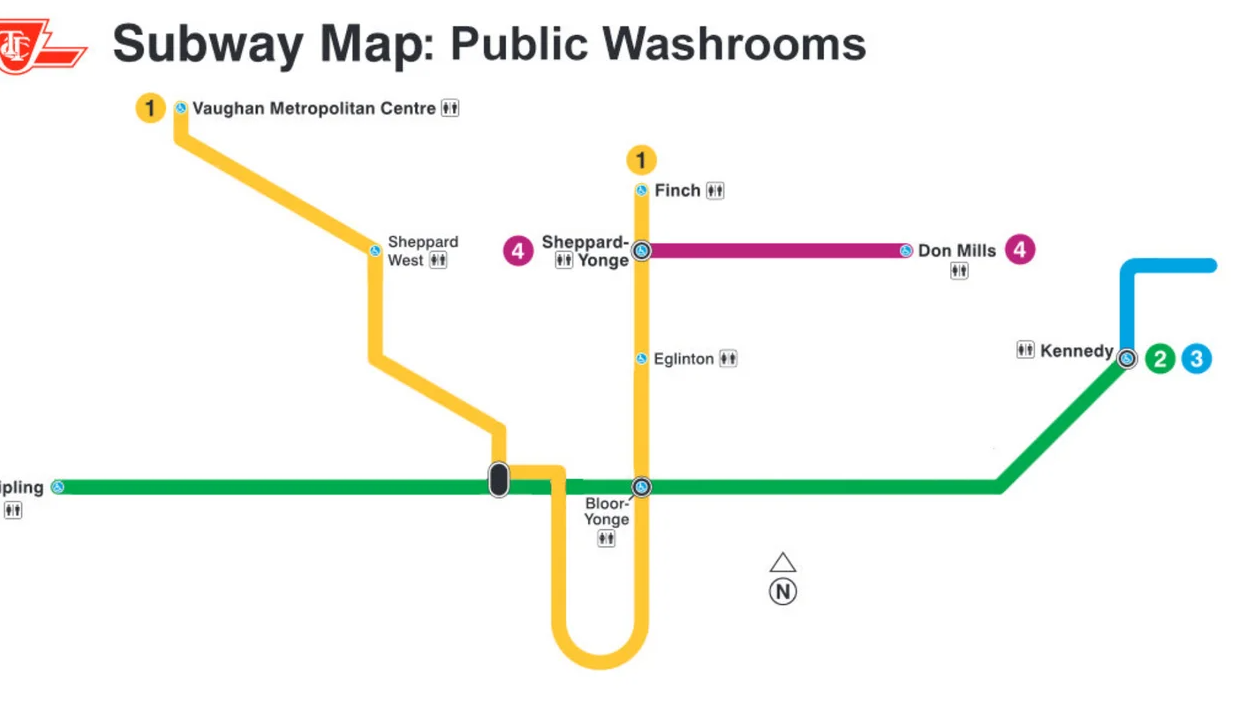

In [ ]:
from IPython.display import Image
image_path = r"/content/washrooms.png"

# Display the image
Image(filename=image_path, width=750, height=450)

In [ ]:
agg3_dd_df.reset_index().rename(columns={'Station': 'Station'}).sort_values(by='impact', ascending=False).head(10)

,Station,count_delay,mean_delay,impact
63,FINCH STATION,1188,2.581650,3067.0
57,EGLINTON STATION,745,3.515436,2619.0
90,KENNEDY BD STATION,602,3.365449,2026.0
92,KENNEDY SRT STATION,185,10.783784,1995.0
201,ST GEORGE YUS STATION,515,3.755340,1934.0
260,YONGE BD STATION,412,4.310680,1776.0
105,KIPLING STATION,491,3.458248,1698.0
138,MCCOWAN STATION,246,6.451220,1587.0
231,VAUGHAN MC STATION,590,2.677966,1580.0
12,BLOOR STATION,661,2.358548,1559.0


To understand the most time wasted on each station, I have prepped another feature i.e. impact by multiplying count_delay and mean_delay. Looking at Stations with worst mean delays wasn't helpful because those Stations had count delays as 1 or 2 (outliers).

Sorting by this new field i.e. count_delays and mean_delays product, shows a few new Stations including Kennedy and McCown Station.

***INTERESTING INSIGHT***
<br> I have also observed that the stations where the trains face the most delay are terminuses and intersections. Vaughan MC, Finch, Kipling, Kennedy and McCown are all terminuses (a.ka. last/first stations) of their lines. This also explains the washrooms on these stations. It is probably these are the busiest ones.

In [ ]:
worst_stations = agg3_dd_df.reset_index().rename(columns={'Station': 'Station'}).sort_values(by='impact', ascending=False).head(10).Station.unique()

Since we cannot investigate all of the stations, I have decided to only look at the aforementioned stations where the most time has been wasted. We'll look at these stations for different hours of the day to understand if there is a pattern. My hypothesis is: certain stations might be facing delays during start and end of the working hours.

In [ ]:
worst_stations_hourly = dd_df[dd_df['Station'].isin(worst_stations)].groupby(['Station', 'Hour']).aggregate({'delay': 'sum'}).reset_index()

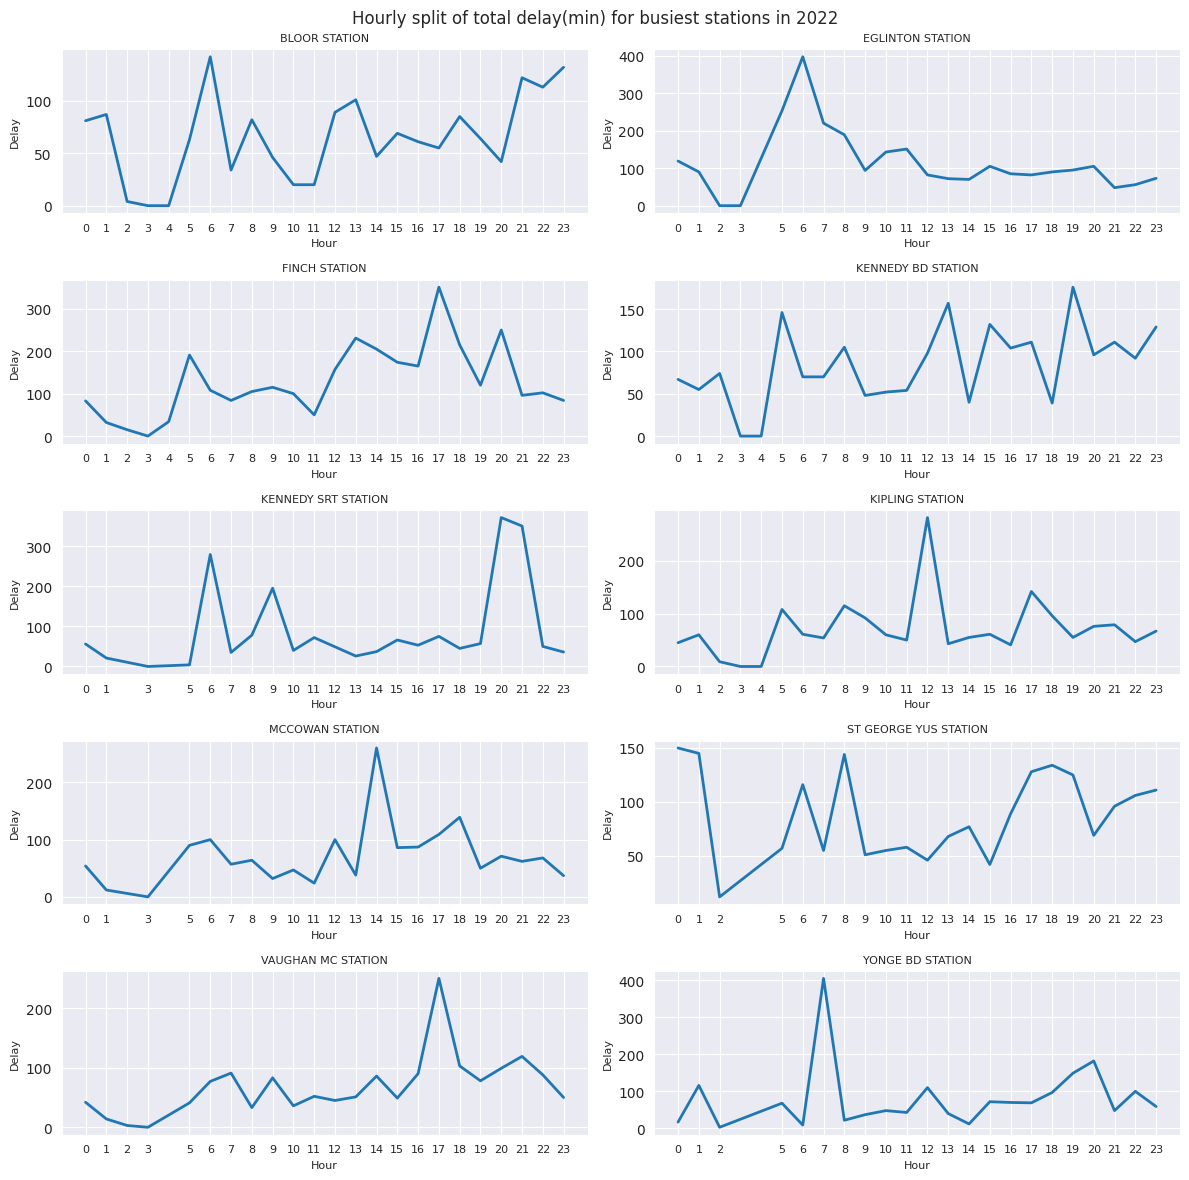

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
axes = axes.flatten()

# Iterate over each station and create a line chart
for i, (station, data) in enumerate(worst_stations_hourly.groupby('Station')):
    ax = axes[i]  # Select the current subplot
    sns.lineplot(data=data, x='Hour', y='delay', ax=ax, linewidth=2)
    ax.set_title(station, fontsize= 8)  # Set the title for each subplot
    ax.set_xlabel('Hour', fontsize= 8)
    ax.set_ylabel('Delay', fontsize= 8)

    ax.set_xticks(data['Hour'])
    ax.tick_params(axis='x', labelsize=8)

plt.suptitle('Hourly split of total delay(min) for busiest stations in 2022')
plt.tight_layout()
plt.show()

There isn't any remarkablely significant trend atleast visibly for these stations based on time except for a few e.g. Yonge BD Station seems to be more affected in the morning. Simiarlly, a few face issues mainly towards the end of the working hours around 5PM to 8PM. But overall, mostly, there isn't anything interesting on time-level atleast on this grain (for stations)

#### Section 3.  Which reasons cause the most delays. Let's see if there are any frequent reasons associated with any stations or lines?

In [ ]:

agg4_dd_df = dd_df.groupby(['code', 'code_desc']).agg({'delay': ['count', 'mean']})
agg4_dd_df.columns = [f'{agg}_{col}' for col, agg in agg4_dd_df.columns]
agg4_dd_df = agg4_dd_df.reset_index().sort_values(by='count_delay', ascending=False).reset_index(drop=True)
agg4_dd_df['pct_contribution_to_overall_delays'] = round(agg4_dd_df['count_delay'] / (agg4_dd_df['count_delay'].sum()) * 100,2)
agg4_dd_df['impact'] = agg4_dd_df['count_delay'] * agg4_dd_df['mean_delay']

pd.set_option('display.max_colwidth', None)
agg4_dd_df.head(15)

,code,code_desc,count_delay,mean_delay,pct_contribution_to_overall_delays,impact
0,MUIS,Injured or ill Customer (In Station) - Transported,1942,0.139547,10.23,271.0
1,SUDP,Disorderly Patron,1897,3.290459,9.99,6242.0
2,MUPAA,Passenger Assistance Alarm Activated - No Trouble Found,1408,1.450284,7.42,2042.0
3,PUOPO,OPTO (COMMS) Train Door Monitoring,1125,3.022222,5.93,3400.0
4,SUO,Passenger Other,984,3.722561,5.18,3663.0
5,MUIRS,Injured or ill Customer (In Station) - Medical Aid Refused,880,0.129545,4.64,114.0
6,MUATC,ATC Project,845,4.533728,4.45,3831.0
7,SUUT,Unauthorized at Track Level,566,10.061837,2.98,5695.0
8,MUSC,Miscellaneous Speed Control,536,0.490672,2.82,263.0
9,PUMEL,Escalator/Elevator Incident,526,0.026616,2.77,14.0


The table above shows top-15 reasons for the delays.

***Insights***
<br> 1. Second most frequent reason, contributing to 10% delays are because of disorderly patron. It could be helpful to evaluate increasing security officials within the subways to avoid these instances.
<br> 2. Third most frequent reason, contributing to about 7.5% of overall delays is passenger assistance alarm activation without an actual trouble. This can be avoided by ensuring a huge fine/penalty.
<br> 3. Another main reason assosciated with assualt case causes about 2.5% of the delays and these are time-costly averaging more than 4 minutes per instance.
<br> 4. Not entirely sure what is this reason comprised of: 'Unauthorized at Track Level', but it seems to be related to 'individuals' since all individual-related codes start wuth 'SU'. These instances are not only the 7th most frequent reason, it also cases a whopping 10 minutes delay on average. Severe penalties might not help it is related to homeless and drunken people on and around the tracks. But this needs to investigated and discussed on policy-level.

Let's also quickly look at the top-15 reasons with highest impact and see if any new reason pop up which isn't an outlier or a one-off.

In [ ]:
agg4_dd_df.sort_values(by='impact', ascending=False).head(15)

,code,code_desc,count_delay,mean_delay,pct_contribution_to_overall_delays,impact
1,SUDP,Disorderly Patron,1897,3.290459,9.99,6242.0
7,SUUT,Unauthorized at Track Level,566,10.061837,2.98,5695.0
49,MUPR1,Priority One - Train in Contact With Person,43,91.209302,0.23,3922.0
6,MUATC,ATC Project,845,4.533728,4.45,3831.0
4,SUO,Passenger Other,984,3.722561,5.18,3663.0
3,PUOPO,OPTO (COMMS) Train Door Monitoring,1125,3.022222,5.93,3400.0
17,MUI,Injured or ill Customer (On Train) - Transported,294,8.795918,1.55,2586.0
14,MUIR,Injured or ill Customer (On Train) - Medical Aid Refused,420,5.452381,2.21,2290.0
10,SUAP,Assault / Patron Involved,501,4.147705,2.64,2078.0
2,MUPAA,Passenger Assistance Alarm Activated - No Trouble Found,1408,1.450284,7.42,2042.0


***Insights***
There aren't many avoidable reasons here. However, 43 train-related accidents where person get in contact is still huge. Not only does look huge, it also cause the longest delays i.e. more than 1.5 hours in each case. Security measures to avoid these cases can be discussed on policy-level.

Let's also have a look at top-5 reasons for each line to see if the reasons for Lines stay consistent or if there are any pattern based on Lines.

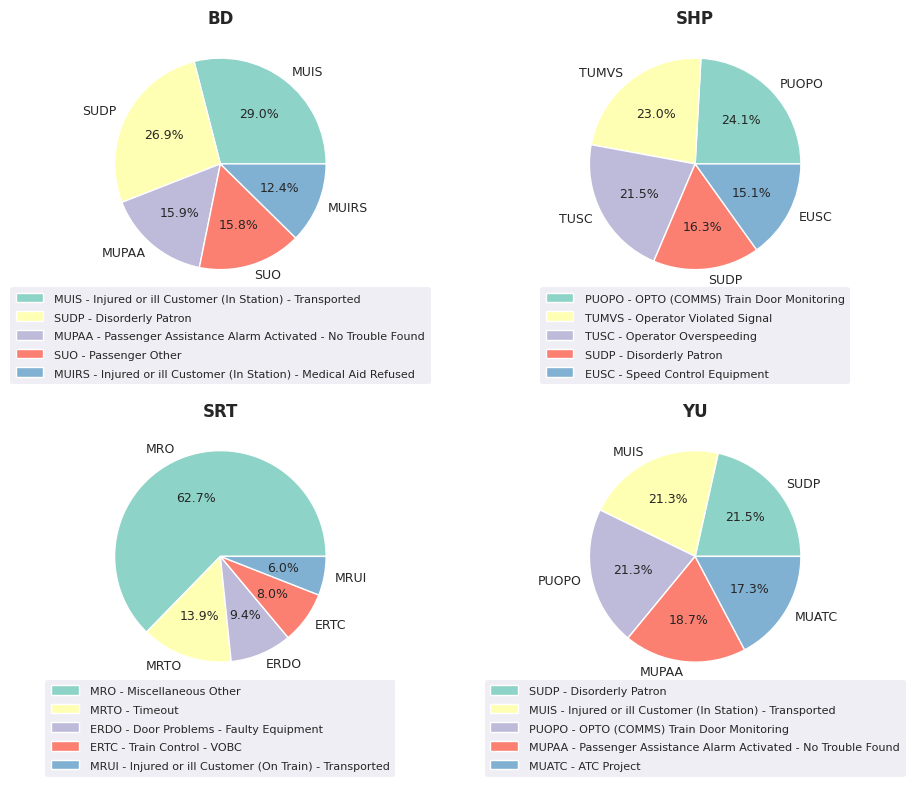

In [ ]:
agg5_dd_df = dd_df.groupby(['Line', 'code', 'code_desc']).agg({'delay': 'count'}).reset_index()
agg5_dd_df = agg5_dd_df.groupby('Line').apply(lambda x: x.nlargest(5, 'delay')).reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, line in enumerate(['BD', 'SHP', 'SRT', 'YU']):
    ax = axes[i // 2, i % 2]
    line_data = agg5_dd_df[agg5_dd_df['Line'] == line]
    patches, texts, _ = ax.pie(line_data['delay'], labels=line_data['code'], autopct='%1.1f%%', colors=sns.color_palette('Set3'), textprops={'fontsize': 9})
    ax.set_title(f'{line}', fontweight='bold')

    legend_labels = line_data['code'] + ' - ' + line_data['code_desc']
    legend = ax.legend(patches, legend_labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=1)

    legend.get_frame().set_linewidth(0)  # Remove legend border
    legend.set_bbox_to_anchor((0.5, -0.15))
    for text in legend.get_texts():
        text.set_fontsize(8)

plt.tight_layout()
plt.show()

Seems like YU and BD face similar problems and the issues they face are also amongst more common we saw. This makes sense because most delays occur on these lines anyway. However, for SHP and SRT, top-5 reasons seem majorly related to TTC service.

***Insights***:
<br> 1. SHP has 'Operator Overspeeding' and 'Operator Violated Signal' as two of the more frequent reasons amongst 5, which can be immidiately corrected as these are staff-related problems. Another top reason is 'Speed Control Equipment' that explains why opertors are violating signals here. Appears to be the trains on this pathway have issues with their speedometers. We can look at vehicle number next to see if we can find the culprit vehciles as well. But will keep that out of scope for this analysis
<br> 2. SRT clearly has poor infrastructure as 'Timeout' and 'Door Problems' are top of the list issues. 'Miscellaneous Other' contributing 63% of the top-5 means the logging of the issues into the system is also extremely poor.

#### Section 4.  Can we find any time-based trends in delays?

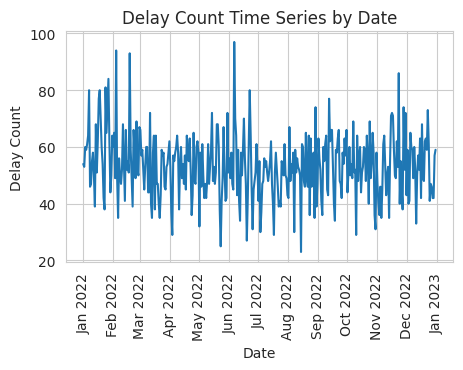

In [ ]:
dd_df['Date'] = pd.to_datetime(dd_df['Date'])
grouped_df = dd_df.groupby(['Date']).agg({'delay': 'count'}).reset_index()

plt.figure(figsize=(5, 3))
sns.set_style("whitegrid")

ax = sns.lineplot(data=grouped_df, x='Date', y='delay')
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Delay Count')
plt.title('Delay Count Time Series by Date')

plt.show()

***Insight***
<br> The overall delay counts for each date produce a time-series which is 'stationary' at sight i.e. static mean, static autocorrelation and station variance. If we want to predict something like 'how many delays would there be tomorrow' we can do it with high accuracy using ARIMA/LSTM etc.

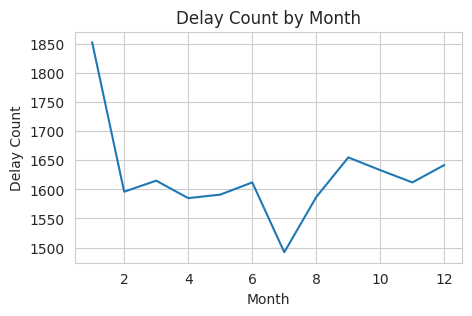

In [ ]:
dd_df['Date'] = pd.to_datetime(dd_df['Date'])
grouped_df = dd_df.groupby(['Month']).agg({'delay': 'count'}).reset_index()

plt.figure(figsize=(5, 3))
sns.set_style("whitegrid")

ax = sns.lineplot(data=grouped_df, x='Month', y='delay')

plt.xlabel('Month')
plt.ylabel('Delay Count')
plt.title('Delay Count by Month')

plt.show()

***Insight***
<br> January faced the most issues which are way higher than the mean of the rest of the year. July faced however the least instances of delays

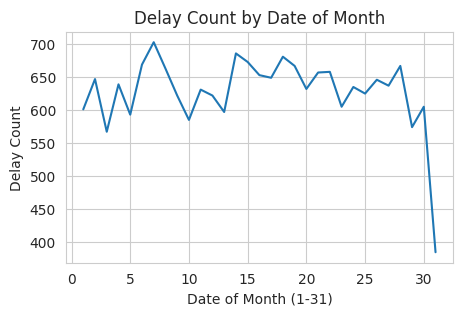

In [ ]:
dd_df['Date'] = pd.to_datetime(dd_df['Date'])
grouped_df = dd_df.groupby(['DOM']).agg({'delay': 'count'}).reset_index()

plt.figure(figsize=(5, 3))
sns.set_style("whitegrid")

ax = sns.lineplot(data=grouped_df, x='DOM', y='delay')

plt.xlabel('Date of Month (1-31)')
plt.ylabel('Delay Count')
plt.title('Delay Count by Date of Month')

plt.show()

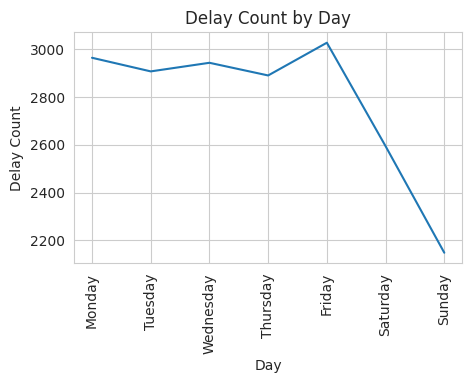

In [ ]:
dd_df['Date'] = pd.to_datetime(dd_df['Date'])
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dd_df['Day'] = pd.Categorical(dd_df['Day'], categories=day_order, ordered=True)

grouped_df = dd_df.groupby('Day').agg({'delay': 'count'}).reset_index()

plt.figure(figsize=(5, 3))
sns.set_style("whitegrid")

ax = sns.lineplot(data=grouped_df, x='Day', y='delay')

plt.xlabel('Day')
plt.xticks(rotation=90)
plt.ylabel('Delay Count')
plt.title('Delay Count by Day')

plt.show()

***Insight***
<br> Issues are slightly higher on Friday and the lowest one weekends, which make sense. We can investigate what type of issues cause this spike on Fridays

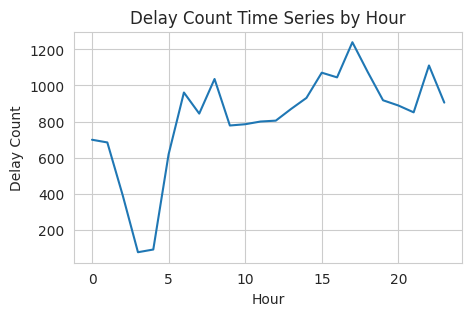

In [ ]:
dd_df['Date'] = pd.to_datetime(dd_df['Date'])
grouped_df = dd_df.groupby(['Hour']).agg({'delay': 'count'}).reset_index()

plt.figure(figsize=(5, 3))
sns.set_style("whitegrid")

ax = sns.lineplot(data=grouped_df, x='Hour', y='delay')

plt.xlabel('Hour')
plt.ylabel('Delay Count')
plt.title('Delay Count Time Series by Hour')

plt.show()

***Insight***
<br>Local maximas can be observed during start of the working hours 6:00 AM to 9:00 AM and another spike (global) can be between 3:00 PM and 5PM which is the end of the day.

#### Section 5.  Can we predict delays?

We cannot predict using this data whether a subway would face a delay or not i.e. binary classification because we only have the data for the delays and there is no data of 'no delay' cases to train a model of such a classifier on. However, if we want to predict the 'duration of the delay' given the information we have including the station where the delay happened, reason identfiied, vehicle being used, we can attempt using the data we have.

We can, also, forecast 'number of delays' for a given day (tomorrow or day after tomorrow etc.) as mentioned earlier in time-series analysis section by using ARIMA, LSTM or Prophet as at initial sight the delay data looked
'stationality'. However, for now, we'll keept this out-of-scope for this exercise.

I'll try to build a model to find the duration of delay as explained above using my favourite model for tabular data i.e. XGBoost. Would not get into the details of hyperparameter optimisation. But the idea of this experiment would be to just test out predictibility and build a base model.

##### a. Feature Selection

Normally feature selection is done after feature importance and correlation tests, but I am leaving a few out at this stage based on what we have learned from EDA so far.

<br> 1. I will keep the feature out of the model i.e.'delay gap' to avoid data leakage. As this seems to be the added gap added in the subway schedule based on 'duration of delay', which we are trying to predict.
<br> 2. I Will also keep 'date' out of it. However, will be using hour, DOM and other time-based features as independent variables i.e. X. Because if we build a model and want to use it to predict duration of delay, we cannot use an exact date as an input. Model can't learn anything from it as it is. However, engineering features out of it i.e. DOM, Hour, Month can be helpful and we'll use them in our model.
<br> 3. I will also not use 'code_desc' as code already is included and they have 1-1 mapping and hence 100% correlation.
<br> 4. I will not leave out the 'bounds' although it has a lot of NULLs because XGBoost can handle NULLs on it own.
<br> 5. We should not use Weekday day as it is, because it is of categorical nature. We need to encode it somehow.
<br> One hot encoding is an option but it introduces too many (7) dimensions, and I try to avoid it whenever I can by using more meaningful methods. We cannot go for label-encoding because we'll lose information we can get from the circular nature of the week. e.g. Monday will be labelled 1 and Sunday will be 7 while these two are only 1 day apart. We will use Angular Distance, introducing following two features.

##### b. Feature Engineering

In [ ]:
dd_df['day_of_week'] = dd_df.Date.dt.weekday
dd_df['Day_sin'] = np.sin(dd_df['day_of_week'] * (2 * np.pi / 7))
dd_df['Day_cos'] = np.cos(dd_df['day_of_week'] * (2 * np.pi / 7))

We found interesting pattern on the basis of weekend as well where propensity of delay was much lower. We will prepare a separate boolean field for weekend as well

In [ ]:
dd_df['is_weekend'] = dd_df['day_of_week'].isin([5, 6])

##### c. Understanding the Target

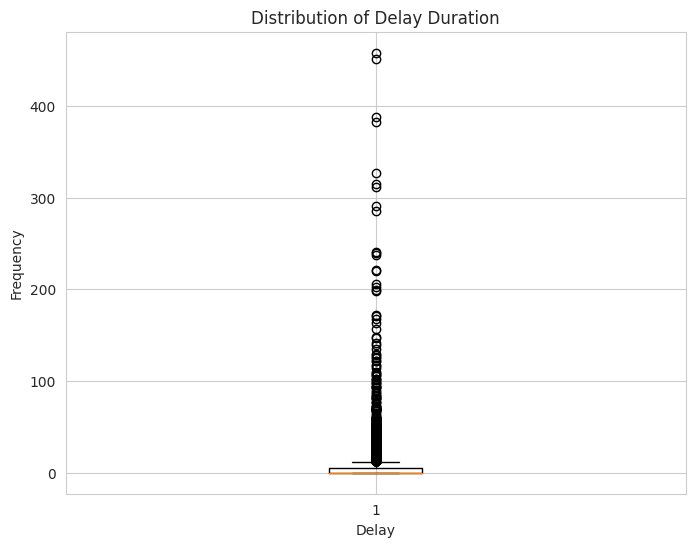

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(dd_df['delay'])
plt.xlabel('Delay')
plt.ylabel('Frequency')
plt.title('Distribution of Delay Duration')
plt.show()

Looks like we cannot build a regression model based on how the delay data is distributed. We can still however, try to build a classifier after binning the target properly into: Short Delay and Long Delay. If we aren't able to build nice even classes, we'll have to explore at anomaly detection techniques where 'anomaly' will be a reasonable amount of delay which we'll decide based on threshold. For now, we'll try to build a binary classifier as mentioned above.

<br> For that, I have prepped a new target feature i.e. delay_type where value is '0' for short delay when delay is for less than a minute, and the value is '1' for long delay when delay is longer than a minute. I have chosen this split because it nicely dissects the two classes and we won't have to worry about class imbalance.

In [ ]:
dd_df['delay_type'] = dd_df['delay'].apply(lambda x: 0 if x==0 else 1)
dd_df.delay_type.value_counts()

0    10500
1     8973
Name: delay_type, dtype: int64

##### d. Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

# Separate the features (X) and the target variable (y)
X = dd_df.drop(['delay_type', 'Date', 'Time', 'Day', 'code_desc', 'added_gap'], axis=1)
y = dd_df['delay_type']

categorical_features = X.select_dtypes(exclude='number').columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Create preprocessor to handle encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Create XGBoostClassifier model
model = XGBClassifier()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

##### e. Model Evaluation

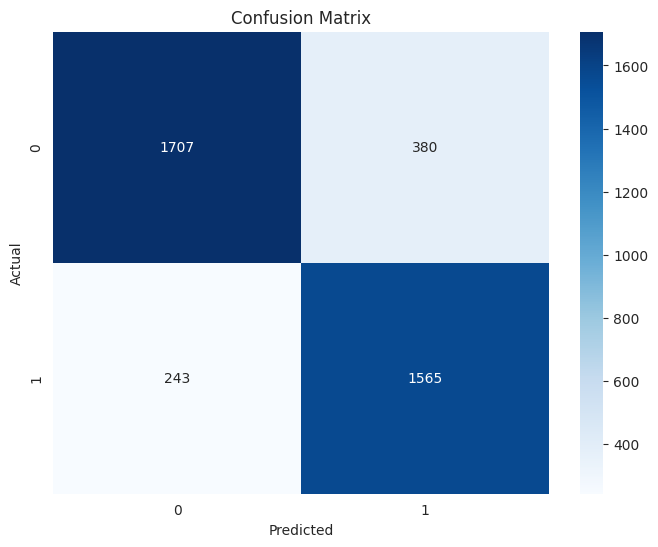

Accuracy: 0.84
Precision: 0.84
Recall: 0.84


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

confusion_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy,2)}")
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {round(precision,2)}")
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {round(recall,2)}")

Base model looks good, with 84% accuracy, and percision and recall, can be improved with feature scaling of numeric fields and via hyper parameter tuning. We should also check via cross validation if we need to tweak anything. We need to also ideally check the error on train dataset to see if we need to tweak regularization.